# Máltækni - Náttúruvernd

# Data import & manipulation

In [1]:
from numpy.random import default_rng
import re
import tqdm
import pandas as pd
import pickle
import numpy as np

In [2]:
#@Vésteinn
def read_news_tsv(file_name):
    data = []
    with open(file_name, encoding="utf-8") as fh:
        for line in tqdm.tqdm(fh.readlines()):
            title, author, url, timestamp, _, _, text, text_tokenized = line.split("\t")
            article = {
                "title": title,
                "author": author,
                "timestamp": timestamp,
                "text": text,
                "text_tokenized": text_tokenized
            }
            data.append(article)
        return data

In [3]:
articles = read_news_tsv("icelandic_news_sample_22480.tsv")
print(f"Article count {len(articles)}")

100%|██████████| 22248/22248 [00:00<00:00, 275155.54it/s]

Article count 22248


In [4]:
articles_df = pd.DataFrame(articles)

In [5]:
articles_Big = read_news_tsv("articles_until_01-11-2020_detok.tsv")
print(f"Article count {len(articles_Big)}")

100%|██████████| 640136/640136 [00:05<00:00, 110756.54it/s]


Article count 640136


In [6]:
news_Big = pd.DataFrame(articles_Big)

In [7]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(news_Big, test_size = 0.15, random_state=11)

In [8]:
print(f'Training data examles: {data_train.shape[0]}')
print(f'Test data examles: {data_test.shape[0]}')

Training data examles: 544115
Test data examles: 96021


In [9]:
data_test, data_test_labeled = train_test_split(data_test, test_size = 0.005, random_state=11)

In [10]:
print(f'Test data examles: {data_test.shape[0]}')
print(f'Labeled test data examles: {data_test_labeled.shape[0]}')

Test data examles: 95540
Labeled test data examles: 481


In [11]:
# Subset af training til að koma virkni í gang án þjálfunartíma
_, data_playground = train_test_split(data_train, test_size = 0.10, random_state=11)
print(f'Playground data examles: {data_playground.shape[0]}')

Playground data examles: 54412


# Skriftupælingar

In [12]:
# Skoðar 'count' margar handahófskenndar fréttir og skilar lista af
# algildum indexum fyrir þær fréttir sem innihalda 'náttúruvernd', 'loftslag' eða 'umhverfi'
def rand_frett(safn, count):
    listi = []
    from numpy.random import default_rng
    import re
    rng = default_rng()
    n = safn.shape[0]
    for i in tqdm.trange(count):
        x = rng.integers(n)
        if pd.isnull(safn.iloc[x]["text"]):
            continue
        frett = safn.iloc[x]["text"] # ath iloc
        frettnr = safn.iloc[x].name
        lykilord = ["náttúruvernd", "loftslag", "umhverfi"]
        fjoldi = 0
        for wrd in lykilord:
            fjoldi += len(re.findall(wrd, frett))
        if fjoldi > 0:
            listi.append(frettnr) # Ath. algildur index
            #print(frett)
    return listi

In [13]:
# Skoðar allar fréttir í gefnu safni og skilar lista með algildum indexum 
# á þeim fréttum sem innihalda fleiri en 'threshold' fjölda af 'náttúruvernd', 'loftslag' eða 'umhverfi'
def allar_frettir(safn, threshold=0):
    listi = []

    n = safn.shape[0]
    for i in tqdm.trange(n):
        frett = safn.iloc[i]["text"]
        lykilord = ["náttúruvernd", "loftslag", "umhverfi"]
        fjoldi = 0
        for wrd in lykilord:
            fjoldi += len(re.findall(wrd, frett))
        if fjoldi > threshold:
            listi.append(i) # ath. afstæð númer m.v. safn
            #print(frett)
    return listi 

In [14]:
# Athuga hvaða hlutfall kemur út úr síunni
sample_count = 100000
big_list = rand_frett(news_Big, sample_count)
print(len(big_list)/sample_count)

100%|██████████| 100000/100000 [00:06<00:00, 16266.22it/s]

0.06764


## Merkjum data_test_labeled

In [15]:
sigtaðar_frettir = allar_frettir(data_test_labeled)

100%|██████████| 481/481 [00:00<00:00, 39527.04it/s]


In [16]:
for fr in sigtaðar_frettir[:3]:
    print(data_test_labeled.iloc[fr])

title             Fyrst var hún hötuð en í dag er hún daglegt brauð
author                                       Ritstjórn Hringbrautar
timestamp                                       2019-04-28 21:09:00
text              (Á mynd: Áður en p-pillan og aðrar getnaðarvar...
text_tokenized    ( Á mynd : Áður en p-pillan og aðrar getnaðarv...
Name: 605530, dtype: object
title                                 „Sá glæsilegasti frá upphafi“
author                                             Ritstjórn mbl.is
timestamp                                       2020-09-05 09:36:00
text              „Veturinn fram undan verður sá þéttasti og glæ...
text_tokenized    „ Veturinn fram undan verður sá þéttasti og gl...
Name: 396081, dtype: object
title                 Tekur við kyndlinum sem tenging við umheiminn
author                                        Bergsteinn Sigurðsson
timestamp                                       2017-04-19 20:15:41
text              Hús sem gert er í nafni Vigdísar Finnbogad

In [17]:
len(sigtaðar_frettir)

38

In [18]:
# for i in sigtaðar_frettir[:3]:
#     frett = data_test_labeled.iloc[i]
#     print(frett["text"])
#     print(frett["title"])
#     einkunn = input("Um náttúruvernd?\n")
#     if einkunn == str(1):
#         ja.append(frett.name)
#     elif einkunn == str(2):
#         vafi.append(frett.name)
#     else:
#         annad.append(frett.name)

In [19]:
# Niðurstöður
jakvætt = {165133,322727,343386,233961,500609,327615}

# !! ATH breyta hér, flokka bara þau sem eru handyfirfarin sem neikvæð 
neikvætt = set(data_test_labeled.index).difference(jakvætt)

print(len(neikvætt))
print(len(jakvætt))
print(data_test_labeled.shape[0])

# data_test_labeled["label"] = np.zeros((len(data_test_labeled), 1), dtype = np.int8)
# for i in jakvætt:
#     data_test_labeled.loc[i,"label"] = 1
# for fr in big_list[:10]:
#     print(news_Big.loc[fr])

475
6
481


## Merkjum data_train

In [20]:
# 'vistaðar niðurstöður' úr flokkun að neðan.
# jákvæðar fréttir úr train
ja =    {285192, 531728, 543888, 290583, 624031, 620326, 586792, 300335, 615601, 57271, 541114, 232512, 203202, 565829, 402387, 212309, 563685, 207852, 319984, 338039, 551033}
# fréttir sem eru kannski já, kannski ekki
vafi =  {188673, 253189, 582670, 549263, 580500, 196829, 138785, 201385, 146412, 624949, 467836, 18621}
# Neikvæðar fréttir sem komu úr síunni
annad = {425218, 398339, 232836, 377475, 40966, 108040, 61449, 411913, 441611, 188049, 594451, 357913, 389534, 447519, 403616, 598944, 403230, 438562, 383270, 300455, 260392, 545578, 245419, 496045, 280365, 111155, 77492, 616884, 26553, 598717, 397246, 264765, 180800, 353226, 292173, 217422, 53844, 179030, 306134, 524889, 622682, 288093, 557662, 146272, 471780, 628965, 111590, 180717, 506996, 129525, 423028, 19063, 409848, 290171}
# # Neikvæðar fréttir teknar af handahófi úr train
neinei = {41758, 45206, 94336, 122610, 133607, 152981, 190982, 210392, 235700, 258454, 276324, 294168, 303348, 328102, 333446, 344739, 351967, 356145, 376980, 426847, 429708, 437621, 460035, 461629, 524825, 566916, 581492, 612748, 631359, 631908}
possibly_corrupt = {628965, 409848, 549263}
print(ja, vafi, annad, sep="\n")
print(len(ja))

{232512, 203202, 565829, 285192, 531728, 543888, 402387, 212309, 290583, 338039, 624031, 563685, 620326, 586792, 207852, 300335, 319984, 615601, 57271, 551033, 541114}
{188673, 138785, 253189, 201385, 146412, 582670, 549263, 580500, 624949, 196829, 467836, 18621}
{425218, 398339, 232836, 377475, 40966, 108040, 61449, 411913, 441611, 188049, 594451, 357913, 389534, 403230, 403616, 598944, 438562, 447519, 383270, 300455, 260392, 545578, 245419, 496045, 280365, 111155, 77492, 616884, 26553, 598717, 397246, 264765, 180800, 353226, 292173, 217422, 53844, 179030, 306134, 524889, 622682, 288093, 557662, 146272, 471780, 628965, 111590, 180717, 506996, 129525, 423028, 19063, 409848, 290171}
21


In [21]:
def label(safn, sigti, count=-1):
    for nr, i in enumerate(sigti[:count]):
        if i in ja or i in vafi or i in annad:
            continue
        frett = safn.loc[i] # Gert er ráð fyrir global index
        print(f"Frétt nr. {nr}")
        print(frett["text"])
        print(frett["title"])
        einkunn = input("Um náttúruvernd?\n")
        print()
        if einkunn == str(1):
            ja.add(frett.name)
        elif einkunn == str(2):
            vafi.add(frett.name)
        elif einkunn == str(0):
            neinei.add(frett.name)
        else:
            annad.add(frett.name)

In [22]:
# label(data_train, data_train.index)

Sigta af handahófi úr train <br>
Flokka sigtað í já og nei<br>
flokka af handahófi úr ósigtuðu (svo nei sé ekki bara sigtað nei)<br>
    - kannski í sér hóp til að sjá hvort það endurspeglist í flokkunum?<br>
Þegar það eru komnir nokkrir tugir í já, þá athuga hvar flokkaða lendir í LDA<br>
Kannski finna gögn sem eru sérstaklega um náttúruvernd, fréttir frá samtökum, Sólin, ...<br>

In [23]:
slembsigti = rand_frett(data_train, 2000) # Hefði kannski átt að setja seed?

100%|██████████| 2000/2000 [00:00<00:00, 15801.77it/s]


In [24]:
# label(data_train, slembsigti)

In [25]:
playground_sigti = allar_frettir(data_playground, 5)

100%|██████████| 54412/54412 [00:01<00:00, 40522.75it/s]


In [26]:
len(playground_sigti)

229

# GENSIM LDA pælingar

In [27]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [28]:
import string
stop_words = set()
extra_stop_words = ["var", "er", "ekki", "sé"]
with open("is_stop_words.txt") as stop_word_file:
    for line in stop_word_file.readlines():
        stop_words.add(line.strip())
stop_words.update(set(string.punctuation))
stop_words.update(set(extra_stop_words))

In [29]:
import tokenizer
from islenska import Bin

b = Bin()

def naive_bin_lemma(token):
    candidates = b.lookup_lemmas_and_cats(token)
    if not candidates:
        return None
    if len(candidates) > 1:
        return None
    cand = candidates.pop()
    if cand[1] not in ["kk", "kvk", "hk"]:
        return None
    return cand[0]


def tokenize_and_lemmatize(sentence):
    if pd.isnull(sentence): # Líklegast óþarft núna
            return []
    tokenized_text = list(tokenizer.split_into_sentences(sentence))
    lemmas = []
    for sent in tokenized_text:
        for token in sent.split():
            if token in stop_words:
                continue
            lemma = naive_bin_lemma(token.lower())
            if lemma is not None: # bæta við stop_words hér? and lemma not in stop_words
                lemmas.append(lemma)
    return lemmas

In [30]:
def load_all():
    with open('data_words.pickle', 'rb') as fh:
        data_words = pickle.load(fh)
    with open('data_words_bigrams.pickle', 'rb') as fh:
        data_words_bigrams = pickle.load(fh)
    with open('id2word.pickle', 'rb') as fh:
        id2word = pickle.load(fh)
    with open('corpus.pickle', 'rb') as fh:
        corpus = pickle.load(fh)
    lda_model = gensim.models.ldamulticore.LdaModel.load("Big_lda_model")
    
    return data_words, data_words_bigrams, id2word, corpus, lda_model

In [31]:
def build_all():
    data_words = [tokenize_and_lemmatize(a) for a in tqdm.notebook.tqdm(data_train["text_tokenized"])]

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    # See trigram example
    # print(trigram_mod[bigram_mod[data_words[0]]])
    data_words_bigrams = make_bigrams(tqdm.tqdm(data_words))
    # Create Dictionary
    id2word = corpora.Dictionary(data_words)

    # Create Corpus
    texts = data_words

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=10, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

In [32]:
def save_all():
    with open('data_words.pickle', 'wb') as fh:
        pickle.dump(data_words, fh)
    with open('data_words_bigrams.pickle', 'wb') as fh:
        pickle.dump(data_words_bigrams, fh)
    with open('id2word.pickle', 'wb') as fh:
        pickle.dump(id2word, fh)
    with open('corpus.pickle', 'wb') as fh:
        pickle.dump(corpus, fh)
    lda_model.save("./Big_lda_model")

In [33]:
data_words, data_words_bigrams, id2word, corpus, lda_model = load_all()

## Tilraunir

In [34]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.041*"maður" + 0.034*"kona" + 0.034*"fólk" + 0.029*"barn" + 0.021*"mynd" + '
  '0.017*"dagur" + 0.015*"fjölskylda" + 0.013*"saga" + 0.012*"rannsókn" + '
  '0.010*"viðtal"'),
 (1,
  '0.061*"lögregla" + 0.027*"dagur" + 0.023*"maður" + 0.023*"morgunn" + '
  '0.022*"klukka" + 0.018*"bíll" + 0.016*"höfuðborgarsvæði" + 0.015*"nótt" + '
  '0.014*"landslið" + 0.014*"land"'),
 (2,
  '0.032*"dagur" + 0.026*"leikmaður" + 0.023*"ísland" + 0.022*"kvöld" + '
  '0.021*"mínúta" + 0.016*"sigur" + 0.014*"mark" + 0.013*"deild" + '
  '0.013*"umferð" + 0.013*"tímabil"'),
 (3,
  '0.033*"dagur" + 0.021*"land" + 0.019*"fólk" + 0.018*"svæði" + 0.013*"íbúi" '
  '+ 0.013*"staður" + 0.010*"yfirvald" + 0.010*"ferðamaður" + 0.010*"fjöldi" + '
  '0.009*"sögn"'),
 (4,
  '0.034*"forseti" + 0.027*"bandaríki" + 0.027*"flokkur" + 0.025*"þingmaður" + '
  '0.020*"dagur" + 0.020*"forsætisráðherra" + 0.018*"ríkisstjórn" + '
  '0.017*"kosning" + 0.015*"þjóð" + 0.015*"íbúð"'),
 (5,
  '0.049*"mál" + 0.038*"frumvarp" + 

In [35]:
# Sjáum orðin tengd ákveðnum flokk
[id2word[i[0]] for i in lda_model.get_topic_terms(6, topn=50)]

['ísland',
 'fólk',
 'verkefni',
 'ákvörðun',
 'breyting',
 'upplýsing',
 'samfélag',
 'einstaklingur',
 'stjórn',
 'starf',
 'vinna',
 'niðurstaða',
 'háskóli',
 'sveitarfélag',
 'áhersla',
 'markmið',
 'stofnun',
 'skýrsla',
 'umræða',
 'dagur',
 'áhrif',
 'hugmynd',
 'þjónusta',
 'samstarf',
 'ís-lending',
 'raun',
 'rannsókn',
 'mál',
 'framtíð',
 'aðgerð',
 'aðili',
 'þjóð',
 'samband',
 'tækifæri',
 'nemandi',
 'regla',
 'áhyggja',
 'starfsmaður',
 'árangur',
 'gagn',
 'ábyrgð',
 'stuðningur',
 'tilkynning',
 'notkun',
 'nefnd',
 'þáttur',
 'skoðun',
 'tillaga',
 'hlutfall',
 'ráðherra']

In [36]:
# Fáum hóp ákveðins orðs í safninu
# Af hverju sýnir þetta fyrir fæst orð?
lda_model.get_term_topics(id2word.token2id["króna"])

[(8, 0.01231972)]

In [37]:
sport = """„Úrslitin eru það mikilvægasta sem við tökum með okkur úr leik kvöldsins. Það er afrek að vinna Porto á útivelli. Að sigra eins og við sigruðum gerir sigurinn enn sætari,“ sagði Jürgen Klopp að loknum 5-1 sigri Liverpool á Drekavöllum í kvöld.
„Það var mikið af góðum augnablikum í leik kvöldsins. Við gátum séð að Porto horfði á leikinn okkar gegn Brentford þar sem þeir voru mjög beinskeyttir, ég vildi lagfæra það á vellinum og við gerðum það skref fyrir skref.“
"""
sport = tokenize_and_lemmatize(sport)

In [38]:
covid= """Í gær greindust 36 einstaklingar innanlands með Covid-19 og voru 28 í sóttkví við greiningu. Tuttugu voru óbólusettir. 348 einstaklingar eru í einangrun hér á landi vegna sjúkdómsins og 1.164 í sóttkví. """
covid=tokenize_and_lemmatize(covid)

In [39]:
def classify(text, verbose=False):
    bow_vector = id2word.doc2bow(text)
    #print(lda_model[bow_vector])
    for index, score in sorted(lda_model[bow_vector][0], key=lambda tup: -1*tup[1]):
        if verbose:
            print("Cluster: {}\t Score: {}\t Topic: {}".format(index, score, lda_model.print_topic(index, 5)))
    if verbose:
        print()
    return(lda_model[bow_vector][0])

In [40]:
def lda_group(indexes, verbose=False):
    mat = np.zeros((len(indexes), 10), dtype=np.float32)
    for i, example in enumerate(tqdm.tqdm(indexes)):
        text = data_train.loc[example]["text_tokenized"] # getur verið news_Big fyrir öll dæmin
        lemm_text = tokenize_and_lemmatize(text)
        vec = classify(lemm_text)
        for group, score in vec:
            mat[i, group] = score
    score_sum = np.sum(mat, axis=0)
    if verbose:
        print(score_sum)
        prin3t(score_sum/sum(score_sum))
        print(-np.sort(-score_sum))
        print(np.argsort(-score_sum))
    return mat

In [41]:
jalist = list(ja)

In [42]:
ja_mat = lda_group(jalist, False)

100%|██████████| 21/21 [00:00<00:00, 22.23it/s]


In [43]:
np.argmax(ja_mat, axis=1)

array([6, 6, 3, 0, 6, 6, 6, 6, 8, 8, 6, 3, 6, 8, 3, 6, 6, 6, 3, 8, 6])

In [44]:
jalist[0]

232512

In [45]:
lda_group([285192])

100%|██████████| 1/1 [00:00<00:00, 59.62it/s]


array([[0.24969345, 0.12265364, 0.03776057, 0.23873852, 0.01138334,
        0.        , 0.1971642 , 0.01023057, 0.11940619, 0.        ]],
      dtype=float32)

In [46]:
data_train.loc[285192]

title                             Nýtt skógarmeindýr annað hvert ár
author                                       Kristín Sigurðardóttir
timestamp                                       2019-09-18 16:34:14
text              Mikið landnám skógarmeindýra á undanförnum þre...
text_tokenized    Mikið landnám skógarmeindýra á undanförnum þre...
Name: 285192, dtype: object

In [47]:
# atta = [3,6,19,20]
# þristur = [8,12,15,16]
# sexa = [1,2,4,5,7,8,9,10,11,13,14,17]
# 
# for i in atta:
#     print(data_train.loc[jalist[i]]["title"])
# print()
# for i in þristur:
#     print(data_train.loc[jalist[i]]["title"])
# print()
# for i in sexa:
#     print(data_train.loc[jalist[i]]["title"])

In [48]:
neineilist = list(neinei)
nei_mat = lda_group(neineilist)
np.argmax(nei_mat, axis=1)

100%|██████████| 30/30 [00:00<00:00, 50.59it/s]


array([6, 4, 3, 3, 3, 1, 8, 7, 0, 4, 8, 7, 3, 3, 1, 9, 3, 0, 8, 9, 2, 6,
       0, 8, 2, 8, 8, 3, 4, 1])

In [49]:
data_train.loc[neineilist[2]]

title                           Smit virðast dreifð víða á Akureyri
author                                           Urður Örlygsdóttir
timestamp                                       2020-10-28 17:48:00
text              Um helgina kom upp smit á Norðurlandi eystra s...
text_tokenized    Um helgina kom upp smit á Norðurlandi eystra s...
Name: 566916, dtype: object

In [50]:
import matplotlib.pyplot as plt
def visual_groups(vigur):
    plt.bar(list(range(10)), vigur)
    plt.show()
    
    plt.bar(range(len(vigur)), -np.sort(-vigur))
    plt.xticks(range(len(vigur)), np.argsort(-vigur))
    plt.show()
    
    # Athuga að sýna líka topphópa ekki bara summu einkunna

100%|██████████| 54/54 [00:07<00:00,  7.12it/s]


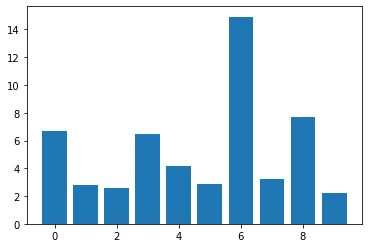

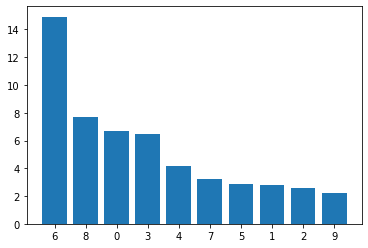

In [51]:
visual_groups(np.sum(lda_group(annad, False), axis=0))

In [52]:
# Keyrir í tæpar 40 mín, stallar á 95% að því er virðist að eilífu
# playground_groups = lda_group(data_playground.index, True)

In [53]:
# Pælingar á ís.

# for j in data_test_labeled[data_test_labeled["label"] == 1]["text"]:
#     classify(tokenize_and_lemmatize(j))
#     print(j, "\n")
# 
# data_test_labeled[data_test_labeled["label"] == 0][:10]["text"]
# for nei in data_test_labeled[data_test_labeled["label"] == 0][:10]["text"]:
#     classify(tokenize_and_lemmatize(nei))
#     print(nei, "\n")
# for nei in data_test_labeled[data_test_labeled["label"] == 0][:10]:
#     print(nei)
#     texti = nei["text"]
#     print(nei["title"])
#     classify(tokenize_and_lemmatize(texti))
#     print(texti, "\n")

# TF IDF pælingar

In [54]:
from gensim import models
from gensim import matutils
import time

In [55]:
tfidf = models.TfidfModel(corpus) # sami corpus og fyrir LDA
corpus_tfidf = tfidf[corpus] # lazy

In [56]:
lsi_200 = models.LsiModel.load("lsi_model_200")
corpus_lsi_200 = lsi_200[corpus_tfidf] 

In [57]:
lsi_500 = models.LsiModel.load("lsi_model_500")
corpus_lsi_500 = lsi_500[corpus_tfidf] 

In [58]:
load = True
if not load:
    t = time.time()
    lsi_model = models.LsiModel(corpus_tfidf, id2word=id2word, num_topics=200)  
    corpus_lsi = lsi_model[corpus_tfidf] 
    print(time.time() - t)

In [59]:
data_train.loc[jalist[2]]["text"]
print(data_words[data_train.index.get_loc(2826)])


['neytendasamtök', 'leigjenda-aðstoð', 'leigjandi', 'íbúðarhúsnæði', 'samningur', 'félagsmálaráðuneyti', 'dagur', 'neytendasamtök', 'þjónusta', 'ár', 'ásmundur', 'félag', 'barnamála-ráðherra', 'samningur', 'formaður', 'neytendasamtök', 'samningur', 'áramót', 'þjónusta', 'samningur', 'leigjandi', 'íbúðarhúsnæði', 'upplýsing', 'húsaleigulög', 'ráðgjöf', 'ágreiningur', 'leigusamningur', 'íbúðarhúsnæði', 'þjónusta', 'leigjandi', 'leigjenda-aðstoð', 'símatími', 'þriðjudagur', 'upplýsing', 'réttindi', 'leigjandi', 'leigjenda-aðstoð']


In [84]:
topic_vector = ["friðland", "andrúmsloft", "umhverfissjónarmið", "loftslagsáhrif", "sjávarborð", "loftslagsvísindi", "ísöld", "náttúruhamfarir", "loftslagslíkan", "friðun", "loftslag-breyting", "umhverfisverndarsinni", "losun", "heildarlosun", "kol", "umhverfisverndarstofa", "umhverfisdómstóll", "auðlindaráðuneyti", "loftslagsstefna", "orkunotkun", "umhverfisskattur", "aðgerðasinni", "hamfarahlýnun", "skref", "útlosun", "lifnaðarháttur", "náttúruauðlind", "náttúruverndarlög", "umhverfisfræði", "orkugjafi", "loftslagsmál", "landnotkun", "úrgangur", "sóun", "útblástur", "gráðurhúsaáhrif", "stóriðja", "kolefnishlutleysi", "umhverfisþing", "umhverfisáhrif", "loftslagsbreyting", "súrnun", "sjór", "vistkerfi", "hringrásarhagkerfi", "sjálfbærni", "parísarsamkomulag", "gróðurhúsalofttegund", "loftslagsaðgerðir", "loftslagsvá", "náttúruvernd", "loftslag", "umhverfi", "náttúra", "hlýnun", "jörð", "loftslagsráðstefna", "þjóðgarður", "bráðna", "jökull", "umhverfisvernd", "mengun", "jarðefnaeldsneyti", "náttúruverðmæti"]
topic_vector.sort()
t = lsi_500[tfidf[id2word.doc2bow(topic_vector)]]
a = corpus_lsi_500[300]
# sama og 
# a = lsi_model[tfidf[corpus[300]]]
matutils.cossim(a, t)

0.02243280872289521

In [62]:
lsi_200.print_topics(10)

[(0,
  '0.223*"lögregla" + 0.177*"leikmaður" + 0.165*"maður" + 0.162*"félag" + 0.151*"dagur" + 0.150*"ísland" + 0.137*"fólk" + 0.129*"kvöld" + 0.123*"mínúta" + 0.123*"kona"'),
 (1,
  '0.315*"lögregla" + -0.279*"leikmaður" + -0.253*"hálfleikur" + -0.249*"mínúta" + -0.229*"sigur" + -0.219*"deild" + -0.169*"úrvalsdeild" + -0.164*"mark" + -0.154*"leikur" + -0.147*"kvöld"'),
 (2,
  '0.579*"lögregla" + -0.172*"félag" + 0.158*"ökumaður" + -0.148*"flokkur" + -0.146*"prósent" + 0.144*"maður" + -0.123*"forseti" + 0.123*"bíll" + -0.119*"milljarður" + 0.116*"mínúta"'),
 (3,
  '-0.500*"félag" + -0.386*"leikmaður" + 0.214*"mínúta" + 0.214*"hálfleikur" + -0.203*"milljón" + 0.186*"flokkur" + 0.154*"sigur" + 0.151*"forseti" + -0.141*"milljarður" + 0.134*"þingmaður"'),
 (4,
  '-0.330*"flokkur" + -0.260*"lögregla" + 0.207*"barn" + -0.203*"prósent" + -0.196*"þingmaður" + -0.174*"sjálfstæðis-flokkur" + -0.156*"félag" + -0.155*"kosning" + 0.155*"mynd" + 0.124*"fólk"'),
 (5,
  '-0.439*"leikmaður" + 0.264*"mi

In [63]:
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
#logging.disable()


In [64]:
#for doc, as_text in zip(corpus_lsi, data_train["text"][:55000]):
#    print(doc, as_text)
#

In [65]:
maxs, maxi = (-1,-1)
for i in range(10000):
    a = lsi_500[tfidf[corpus[i]]]
    sim = matutils.cossim(a,t)
    if sim > maxs:
        maxs = sim
        maxi = i
print(maxs, maxi)

0.7999960960194807 2826


In [81]:
topic_vector

['andrúmsloft',
 'auðlindaráðuneyti',
 'aðgerðasinni',
 'bráðna',
 'friðun',
 'gráðurhúsaáhrif',
 'gróðurhúsalofttegund',
 'hamfarahlýnun',
 'heildarlosun',
 'hlýnun',
 'hringrásarhagkerfi',
 'jarðefnaeldsneyti',
 'jökull',
 'jörð',
 'kol',
 'kolefnishlutleysi',
 'landnotkun',
 'lifnaðarháttur',
 'loftslag',
 'loftslag-breyting',
 'loftslagsaðgerðir',
 'loftslagsbreyting',
 'loftslagslíkan',
 'loftslagsmál',
 'loftslagsráðstefna',
 'loftslagsstefna',
 'loftslagsvá',
 'loftslagsvísindi',
 'loftslagsáhrif',
 'losun',
 'mengun',
 'náttúra',
 'náttúruauðlind',
 'náttúruhamfarir',
 'náttúruvernd',
 'náttúruverndarlög',
 'náttúruverðmæti',
 'orkugjafi',
 'orkunotkun',
 'parísarsamkomulag',
 'sjálfbærni',
 'sjávarborð',
 'sjór',
 'skref',
 'stóriðja',
 'sóun',
 'súrnun',
 'umhverfi',
 'umhverfisdómstóll',
 'umhverfisfræði',
 'umhverfissjónarmið',
 'umhverfisskattur',
 'umhverfisvernd',
 'umhverfisverndarsinni',
 'umhverfisverndarstofa',
 'umhverfisáhrif',
 'umhverfisþing',
 'vistkerfi',
 'ísö

In [66]:
for i in range(10000):
    a = lsi_200[tfidf[corpus[i]]]
    sim = matutils.cossim(a,t)
    if sim > 0.4:
        print(data_train.iloc[i]["title"])



In [78]:
for i in jalist:
    a = corpus_lsi_500[data_train.index.get_loc(i)]
    sim = matutils.cossim(a,t)
    print(sim, data_train.loc[i]["title"])

0.5123703398629668 Segja loftslagsvána ekki raunverulega
0.6386845049222059 Kerfisbreytingar eiga að snúast um loftslagsbreytingar
0.37754608342761603 Varpa nýju ljósi á loftslagsbreytingar
0.3873552676439344 Nýtt skógarmeindýr annað hvert ár
0.4458907502267 Trump getur ekki afnumið loftslagsaðgerðir með töfrasprota
0.18441685120051762 Guðlaugur Þór stýrði utanríkisráðherrafundi NB8 og Visegrad-ríkja
0.3431356859085665 Undirrituðu yfirlýsingu um vatnsöryggi
0.22592427400246126 Katrín ætlar að ræða við Guðna um að Svandís verði sett yfir nokkrum málum Guðmundar
0.060430130793518444 Gera ekki athugasemdir við umhverfisvænt fiskeldi
0.13634147426099263 Hrygning bleikju hafin í vötnum landsins
0.3850365522495037 Umhverfisþing hafið í Hörpu 
0.23902998246538248 Hitamet staðfest á einum kaldasta stað jarðar
0.4587271247055451 Vilja sóðaskatt og allir verði vegan
0.24148444387948592 „Orð eru ódýr en aðgerðir kosta“
0.2590075850719728 Vatnsskortur yfirvofandi í Danmörku – Miklir þurrkar ógna g

In [76]:
data_train.loc[jalist[8]]["title"]

'Gera ekki athugasemdir við umhverfisvænt fiskeldi'

In [69]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12)


In [74]:
query_document = topic_vector


In [75]:
query_bow = id2word.doc2bow(query_document)


In [ ]:
# Krassar
# sims = index[tfidf[query_bow]]
index.get_similarities(tfidf[id2word.doc2bow(topic_vector)])


In [ ]:
print(list(enumerate(sims)))

# NER

In [86]:
from transformers import AutoModelForTokenClassification
from transformers import pipeline
from transformers import AutoTokenizer
    
model = AutoModelForTokenClassification.from_pretrained("eliasbe/IceBERT-finetuned-ner")
tokenizer = AutoTokenizer.from_pretrained("eliasbe/IceBERT-finetuned-ner")
iceb = pipeline("ner", model=model, tokenizer=tokenizer)

In [96]:
modelX = AutoModelForTokenClassification.from_pretrained("eliasbe/XLMR-ENIS-finetuned-ner")
tokenizerX = AutoTokenizer.from_pretrained("eliasbe/XLMR-ENIS-finetuned-ner")
xlmr = pipeline("ner", model=modelX, tokenizer=tokenizerX)

Það er hámarkslengd á inputi í þessi módel, þarf að finna lausn á því

In [ ]:
xlmr(data_train.loc[jalist[1]]["text_tokenized"])

In [222]:

# Athuga að við viljum væntanlega halda utan um staðsetningu líka
def get_names(text):
    l = list()
    end = -1
    beg = False
    for entry in xlmr(text):
        if entry['entity'] in {'B-Person', 'I-Person'}:                               
            word = entry['word'].strip() 
            if word in set(string.punctuation):
                end = int(entry['end'])
                continue
            if word[0] == '▁':
                word = word[1:]
                beg = True
            if end == int(entry['start']):
                last = l[-1]
                if beg:
                    nxt = " ".join([last, word])
                else:
                    nxt = "".join([last, word])
                l = l[:-1]
                l.append(nxt)
            else:
                l.append(word)
            end = int(entry['end'])
        beg = False
    #for nafn in l:
    #    if nafn[-1] in set(string.punctuation):
    #        print("ja", nafn)
    #        nafn = nafn[:-1]
    #        print(nafn)
    l = set(l)
    return l
            

In [223]:
get_names(alþingi[0])

{'Adda María Jóhannsdóttir'}

In [264]:
def nefnifall(nafnalisti):
    out = list()
    for nafn in nafnalisti:
        temp = list()
        cats = list()
        nöfn = nafn.split()
        
        # Athuga ef nöfnin hafa mörg kyn, kjósa um það
        for n in nöfn:
            kyn = list(b.lookup_cats(n))
            for k in kyn:
                cats.append(k)
        if len(set(cats)) > 1:
            k = max(set(cats), key=cats.count)
        elif cats:
            k = cats[0]
        #print(k)
        # Setja nefnifallið í lista
        for n in nöfn:   
            try:
                variant = b.lookup_variants(n, k, ("NF", "ET"))
            except:
                variant = None
            #print(variant)
            if variant: 
                temp.append(variant[0].bmynd)
            else:
                temp.append(n)
        out.append(" ".join(temp))
    return out

In [182]:
nefnifall(get_names(data_train.loc[jalist[3]]["text_tokenized"]))

['Guðmundur Halldórsson', 'Brynja Hrafnkelsdóttir', 'Edda S. Oddsdóttir']

In [183]:
alþingi_sample = ["Adda María Jóhannsdóttir. Varaþingmaður Suðvesturkjördæmis febrúar 2018 (Samfylkingin).", "Adda Bára Sigfúsdóttir. Varaþingmaður Reykvíkinga nóvember 1957 (Alþýðubandalag).", "Adolf H. Berndsen. Alþingismaður Norðurlands vestra 2003 (Sjálfstæðisflokkur)."]
for sentence in alþingi_sample:
    print(get_names(sentence))
    print(nefnifall(get_names(sentence)))

{'Adda María Jóhannsdóttir.'}
['Adda María Jóhannsdóttir.']
{'Adda Bára Sigfúsdóttir'}
['Adda Bára Sigfúsdóttir']
{'Adolf H. Berndsen'}
['Adolf H. Berndsen']


In [238]:
def get_party(text):
    l = list()
    end = -1
    beg = False
    for entry in xlmr(text):
        if entry['entity'] == 'B-Organization':                               
            word = entry['word']
            if word in set(string.punctuation):
                end = int(entry['end'])
                continue
            if word[0] == '▁':
                word = word[1:]
                beg = True
            if word[0] in set(string.punctuation):
                word = word[1:]
            if end == int(entry['start']):
                last = l[-1]
                if beg:
                    nxt = " ".join([last, word])
                else:
                    nxt = "".join([last, word])
                l = l[:-1]
                l.append(nxt)
            else:
                l.append(word) # Athuga með að sía fyrir raunverulegum flokkum
            end = int(entry['end'])
        beg = False
    l = set(l)
    return l
            

In [240]:
# https://www.althingi.is/altext/cv/is/
with open("Alþingismenn.txt", "r") as f:
    alþingi = f.readlines()

member_party = dict()
for sentence in alþingi:
    
    # ML methods
    member = get_names(sentence)
    party = get_party(sentence)
    
    # RE methods
    # search = re.search("^(.*)\. ", sentence)
    # member = search[0]
    # party = re.finditer("\((.*)\)\.", sentence)
    
    #print(member, party)
    for m in member:       
        member_party[m] = party

In [246]:
flokkar = set()
for it in member_party.values():
    for i in it:
        flokkar.add(i)

In [249]:
# Ath að einræða flokka, greinir/ekki greinir
flokkarsia = {'Alþýðubandalag',
 'Alþýðubandalagið',
 'Alþýðuflokkur',
 'Alþýðuflokkurinn',
 'Borgaraflokkur',
 'Borgaraflokkurinn',
 'Borgarahreyfingin',
 'Bændaflokkur',
 'Bændaflokkurinn',
 'Framfaraflokkurinn',
 'Framsóknar',
 'Framsóknarflokkur',
 'Framsóknarflokkurinn',
 'Frjálslyndi',
 'Heimastjórnarflokkurinn',
 'Kommúnistaflokkurinn',
 'Landvarnarflokkurinn',
 'Miðflokkurinn',
 'Píratar',
 'Sambandsflokkurinn',
 'Sameiningarflokkur',
 'Samfylkingin',
 'Sjálfstæðisflokkur',
 'Sjálfstæðisflokkurinn',
 'Sparnaðarbandalagið',
 'Sósíalistaflokkur',
 'Sósíalistaflokkurinn',
 'Utanflokkabandalagið',
 'Vinstrihreyfingin',
 'Viðreisn',
 'Árnesinga',
 'Íhaldsflokkurinn',
 'Þjóðræðisflokkurinn',
 'Þjóðvaki',
 'Þjóðvarnarflokkurinn',}

In [250]:
Vandkvæði = {'vennalistinn',
'reisn',
'ramsóknarflokkur',
'Vinstrihreyf\xadingin',
'Hreyfingin',
'Björt',
'Alþýðu',
'þingflokkur'}

In [274]:
data_train.loc[jalist[5]]

title             Guðlaugur Þór stýrði utanríkisráðherrafundi NB...
author                                           Utanríkisráðuneyti
timestamp                                       2019-04-01 12:48:00
text              Öryggis-og varnarmál, þróun mála í Evrópu og m...
text_tokenized    Öryggis- og varnarmál , þróun mála í Evrópu og...
Name: 543888, dtype: object

In [277]:
text = data_train.loc[543888]["text"]
names = get_names(text)
names_nf = nefnifall(names)
for n in names:
    if n in member_party:
        print(n, member_party[n])
print()
print(names, names_nf)

Guðlaugur Þór Þórðarson {'Sjálfstæðisflokkur'}

{'Guðlaugur Þór', 'Guðlaugur Þór Þórðarson'} ['Guðlaugur Þórr', 'Guðlaugur Þórr Þórðarson']


Ath f. frétt 543888, nefnifall bætir við r-i aftan á 'Þór'!

In [289]:
with open("Current_alþingismenn.txt", "r") as f:
    current_alþingi = f.readlines()

current_member_party = dict()
for line in current_alþingi:
    line = line.strip()
    line = line.split("   ")
    current_member_party[line[0]] = line[1]
    
current_member_party

{'Andrés Ingi Jónsson': 'Píratar',
 'Arndís Anna Kristínardóttir Gunnarsdóttir': 'Píratar',
 'Ágúst Bjarni Garðarsson': 'Framsóknarflokkur',
 'Áslaug Arna Sigurbjörnsdóttir': 'Sjálfstæðisflokkur',
 'Ásmundur Einar Daðason': 'Framsóknarflokkur',
 'Ásmundur Friðriksson': 'Sjálfstæðisflokkur',
 'Ásthildur Lóa Þórsdóttir': 'Flokkur fólksins',
 'Berglind Ósk Guðmundsdóttir': 'Sjálfstæðisflokkur',
 'Bergþór Ólason': 'Miðflokkurinn',
 'Birgir Ármannsson': 'Sjálfstæðisflokkur',
 'Birgir Þórarinsson': 'Sjálfstæðisflokkur',
 'Bjarkey Olsen Gunnarsdóttir': 'Vinstrihreyfingin - grænt framboð',
 'Bjarni Benediktsson': 'Sjálfstæðisflokkur',
 'Bjarni Jónsson': 'Vinstrihreyfingin - grænt framboð',
 'Björn Leví Gunnarsson': 'Píratar',
 'Bryndís Haraldsdóttir': 'Sjálfstæðisflokkur',
 'Diljá Mist Einarsdóttir': 'Sjálfstæðisflokkur',
 'Eyjólfur Ármannsson': 'Flokkur fólksins',
 'Gísli Rafn Ólafsson': 'Píratar',
 'Guðbrandur Einarsson': 'Viðreisn',
 'Guðlaugur Þór Þórðarson': 'Sjálfstæðisflokkur',
 'Guðmun